In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install texlive-latex-recommended
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended

In [ ]:
%%capture
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip

In [ ]:
!unzip type1cm.zip -d /tmp/type1cm

Archive:  type1cm.zip
   creating: /tmp/type1cm/type1cm/
  inflating: /tmp/type1cm/type1cm/type1cm.fdd  
  inflating: /tmp/type1cm/type1cm/type1cm.ins  
  inflating: /tmp/type1cm/type1cm/type1cm.txt  
  inflating: /tmp/type1cm/type1cm/type1cm-doc.pdf  
  inflating: /tmp/type1cm/type1cm/type1cm-doc.tex  


In [ ]:
%%capture
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins

In [ ]:
%%capture
!sudo mkdir /usr/share/texmf/tex/latex/type1cm
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
!sudo texhash
!apt install cm-super

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from statsmodels.stats.multitest import multipletests

In [ ]:
sns.set(style="white")

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.size" : 15,
    "text.usetex": False,
    "pgf.rcfonts": False,
    "text.color" : "black"
})

In [ ]:
%matplotlib inline

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24
MAXIMUM_SIZE = 30

plt.rc("font", size=MEDIUM_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc("xtick", labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc("figure", titlesize=MAXIMUM_SIZE)   # fontsize of the figure title

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
default_attns = np.load("drive/My Drive/bert_attn_experiments/default_attns.npy")
finetuned_regular_attns = np.load("drive/My Drive/bert_attn_experiments/finetuned_regular_attns.npy")
finetuned_polypers_attns = np.load("drive/My Drive/bert_attn_experiments/finetuned_polypers_attns.npy")

In [ ]:
N, L, H = default_attns.shape

In [ ]:
mean_default = default_attns.mean(axis=0)
mean_finetuned_regular = finetuned_regular_attns.mean(axis=0)
mean_finetuned_polypers = finetuned_polypers_attns.mean(axis=0)

In [ ]:
def plot_three_heatmaps(
    item_list, titles, save_path,
    cmap="RdBu_r", figsize=(26, 7),
    vmin=None, vmax=None
):
    if vmin == None:
        vmin = min(item.min() for item in item_list)
    if vmax == None:
        vmax = max(item.max() for item in item_list)

    fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=False)

    ims = []
    for i, (item, title) in enumerate(zip(item_list, titles)):
        ax = axes[i]
        im = ax.imshow(item, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto")
        ims.append(im)
        ax.set_title(title)
        ax.set_xlabel("Head")
        ax.set_ylabel("Layer")
        n_rows, n_cols = item.shape
        ax.set_xticks(list(range(0, n_cols)))
        ax.set_yticks(list(range(0, n_rows)))

    cbar = fig.colorbar(ims[-1], ax=axes.ravel().tolist(), orientation="vertical",
                        fraction=0.05, pad=0.02)

    fig.show()

    plt.savefig(save_path)

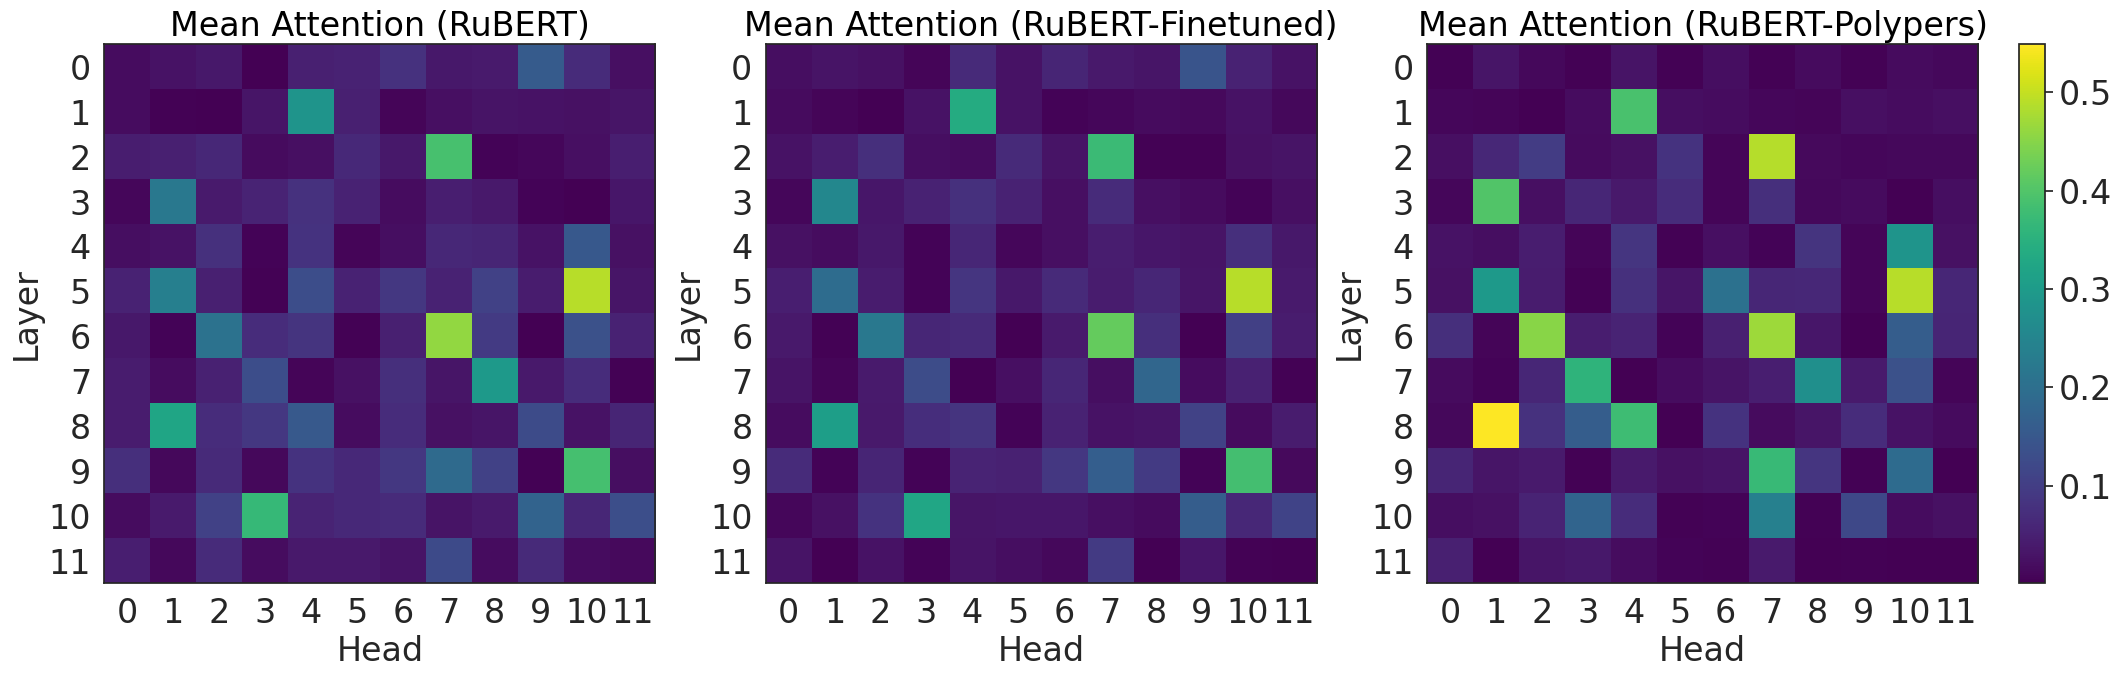

In [ ]:
plot_three_heatmaps(
    [mean_default, mean_finetuned_regular, mean_finetuned_polypers],
    titles=["Mean Attention (RuBERT)", "Mean Attention (RuBERT-Finetuned)", "Mean Attention (RuBERT-Polypers)"],
    cmap=sns.color_palette("viridis", as_cmap=True),
    save_path="all_attns.pgf"
)

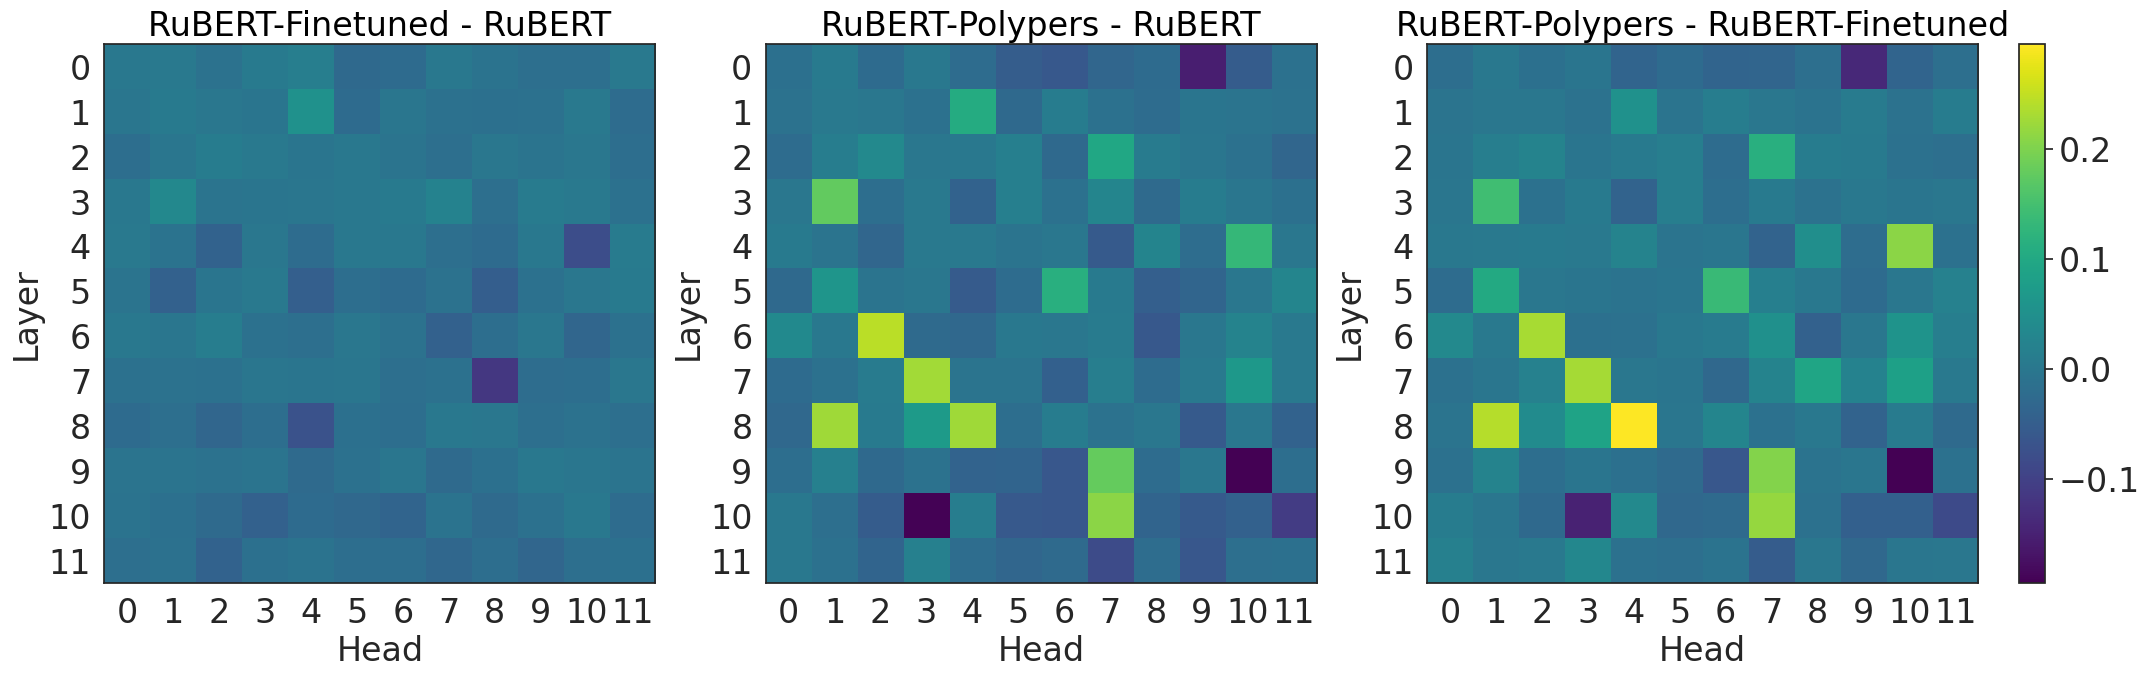

In [ ]:
plot_three_heatmaps(
    [mean_finetuned_regular - mean_default, mean_finetuned_polypers - mean_default, mean_finetuned_polypers - mean_finetuned_regular],
    ["RuBERT-Finetuned - RuBERT", "RuBERT-Polypers - RuBERT", "RuBERT-Polypers - RuBERT-Finetuned"],
    cmap=sns.color_palette("viridis", as_cmap=True),
    save_path="all_attn_diffs.pgf"
)

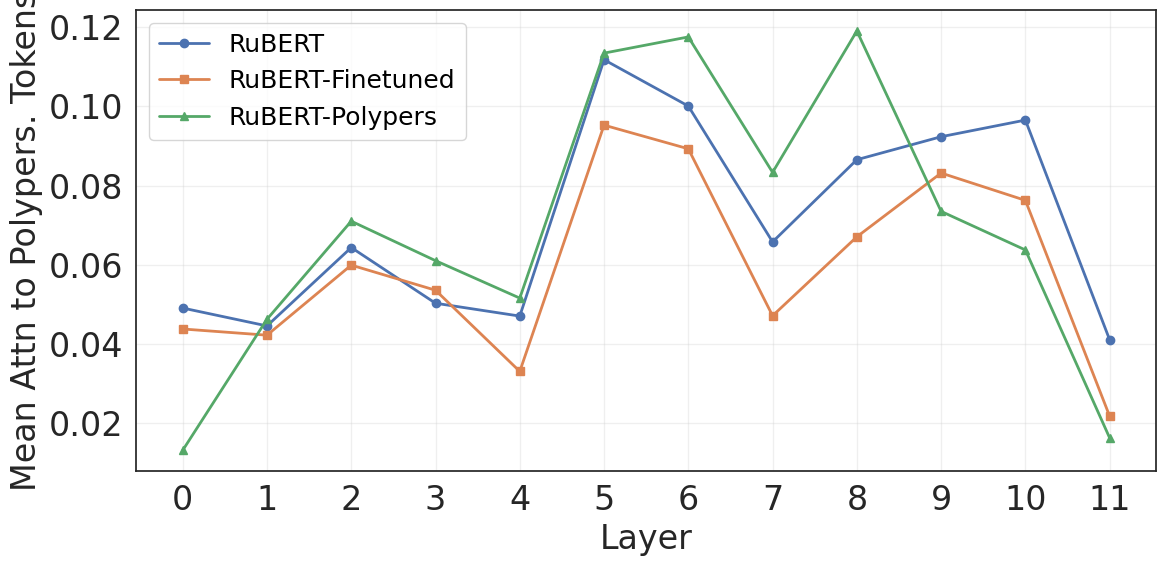

In [ ]:
layer_means_default = np.mean(default_attns, axis=(0, 2))  # Mean over sentences and heads
layer_means_regular = np.mean(finetuned_regular_attns, axis=(0, 2))
layer_means_polypers = np.mean(finetuned_polypers_attns, axis=(0, 2))

fig, ax = plt.subplots(figsize=(12, 6))
layers = np.arange(12)
plt.plot(layers, layer_means_default, marker="o", label="RuBERT", linewidth=2)
plt.plot(layers, layer_means_regular, marker="s", label="RuBERT-Finetuned", linewidth=2)
plt.plot(layers, layer_means_polypers, marker="^", label="RuBERT-Polypers", linewidth=2)
plt.xlabel("Layer")
plt.xticks(list(range(0, 12)))
plt.ylabel("Mean Attn to Polypers. Tokens")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
fig.show()

plt.savefig("layerwise.pgf")

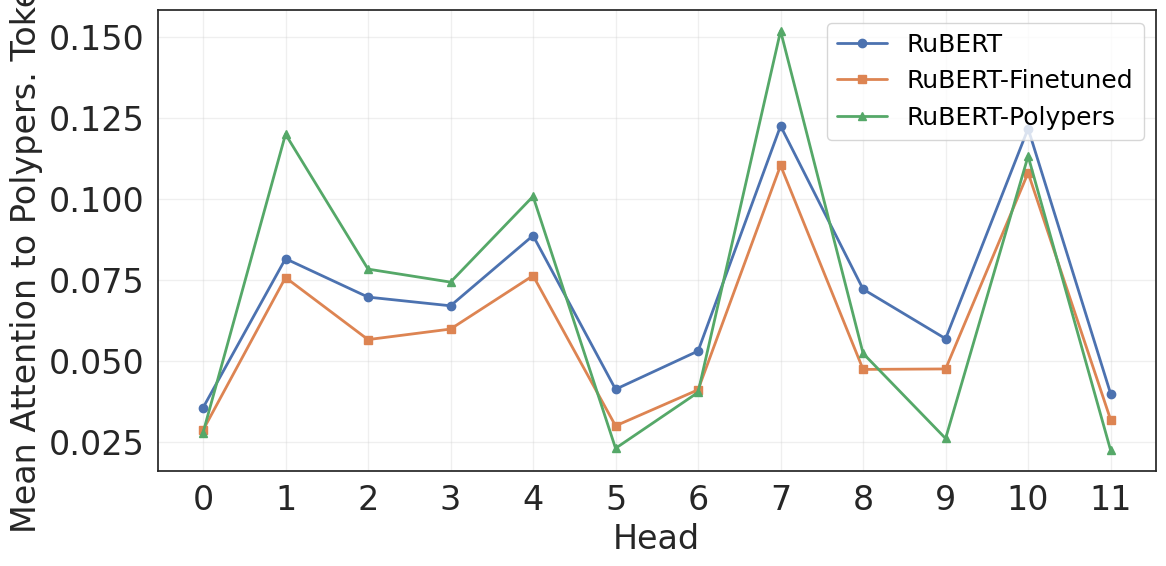

In [ ]:
head_means_default = np.mean(default_attns, axis=(0, 1))  # Mean over sentences and layers
head_means_regular = np.mean(finetuned_regular_attns, axis=(0, 1))
head_means_polypers = np.mean(finetuned_polypers_attns, axis=(0, 1))

fig, ax = plt.subplots(figsize=(12, 6))
heads = np.arange(12)
plt.plot(heads, head_means_default, marker="o", label="RuBERT", linewidth=2)
plt.plot(heads, head_means_regular, marker="s", label="RuBERT-Finetuned", linewidth=2)
plt.plot(heads, head_means_polypers, marker="^", label="RuBERT-Polypers", linewidth=2)
plt.xlabel("Head")
plt.xticks(list(range(0, 12)))
plt.ylabel("Mean Attention to Polypers. Tokens")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
fig.show()

plt.savefig("headwise.pgf")

Checking normality for RuBERT-Finetuned vs RuBERT:


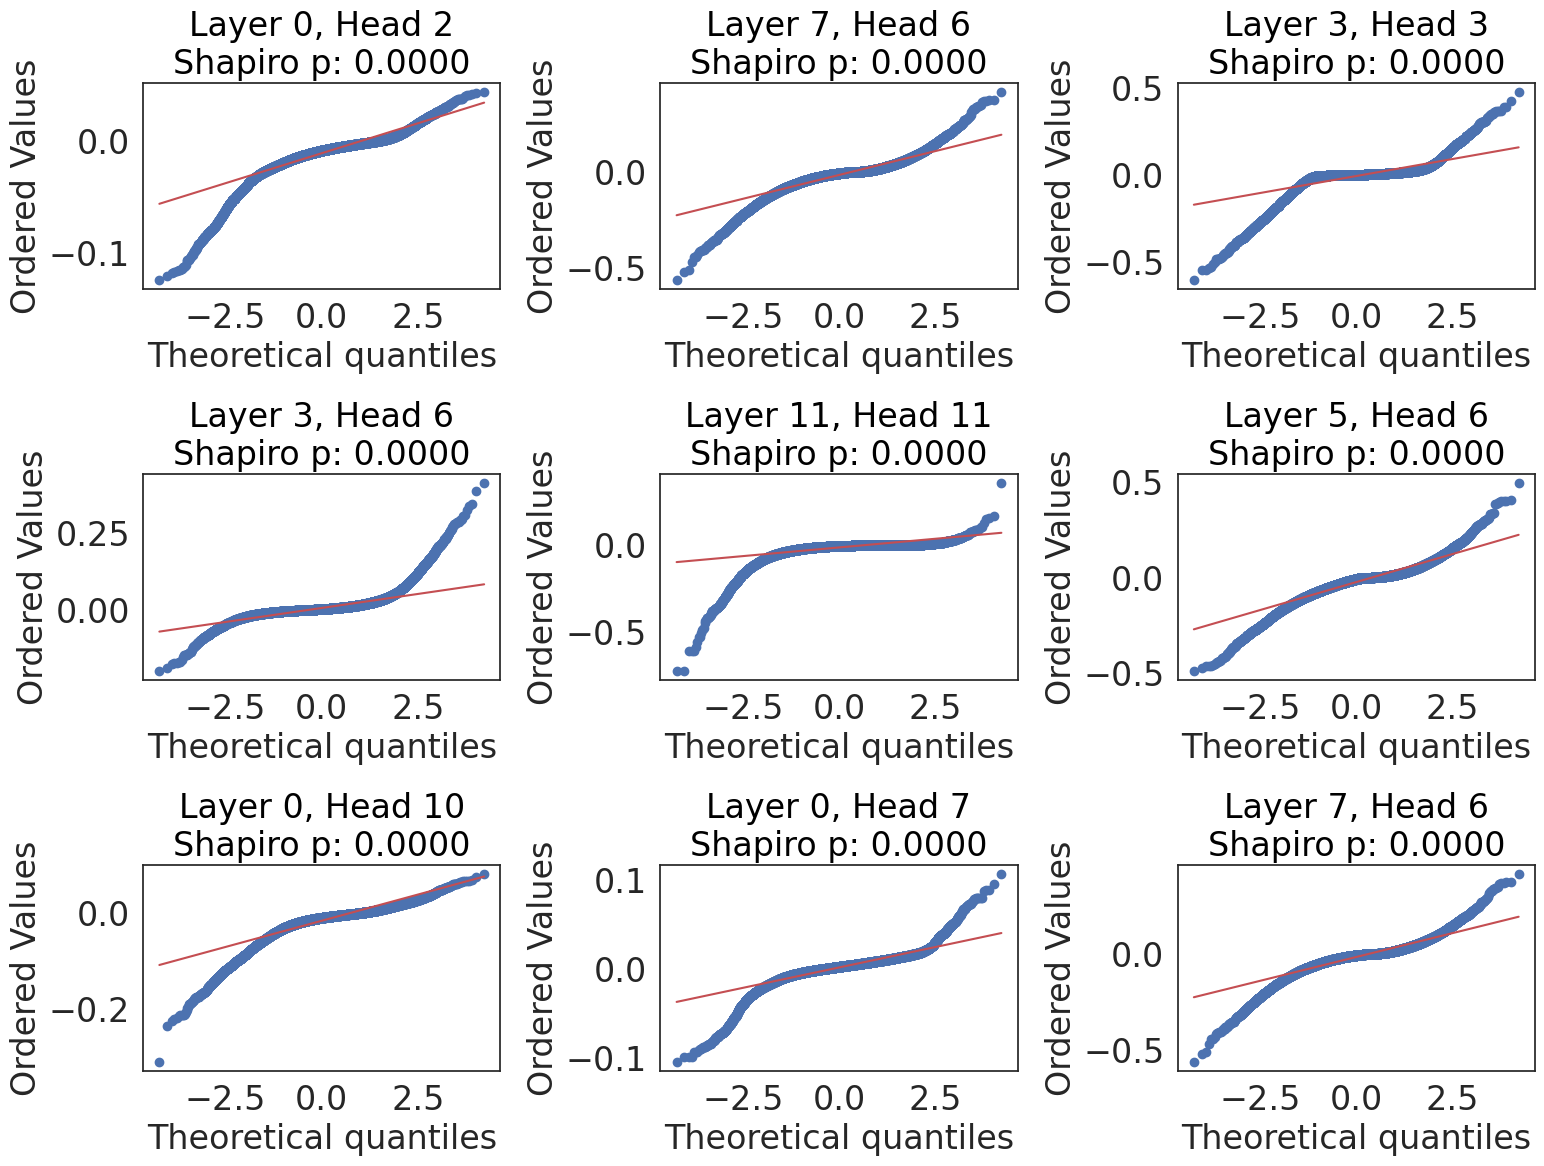

Checking normality for RuBERT-Polypers vs RuBERT:


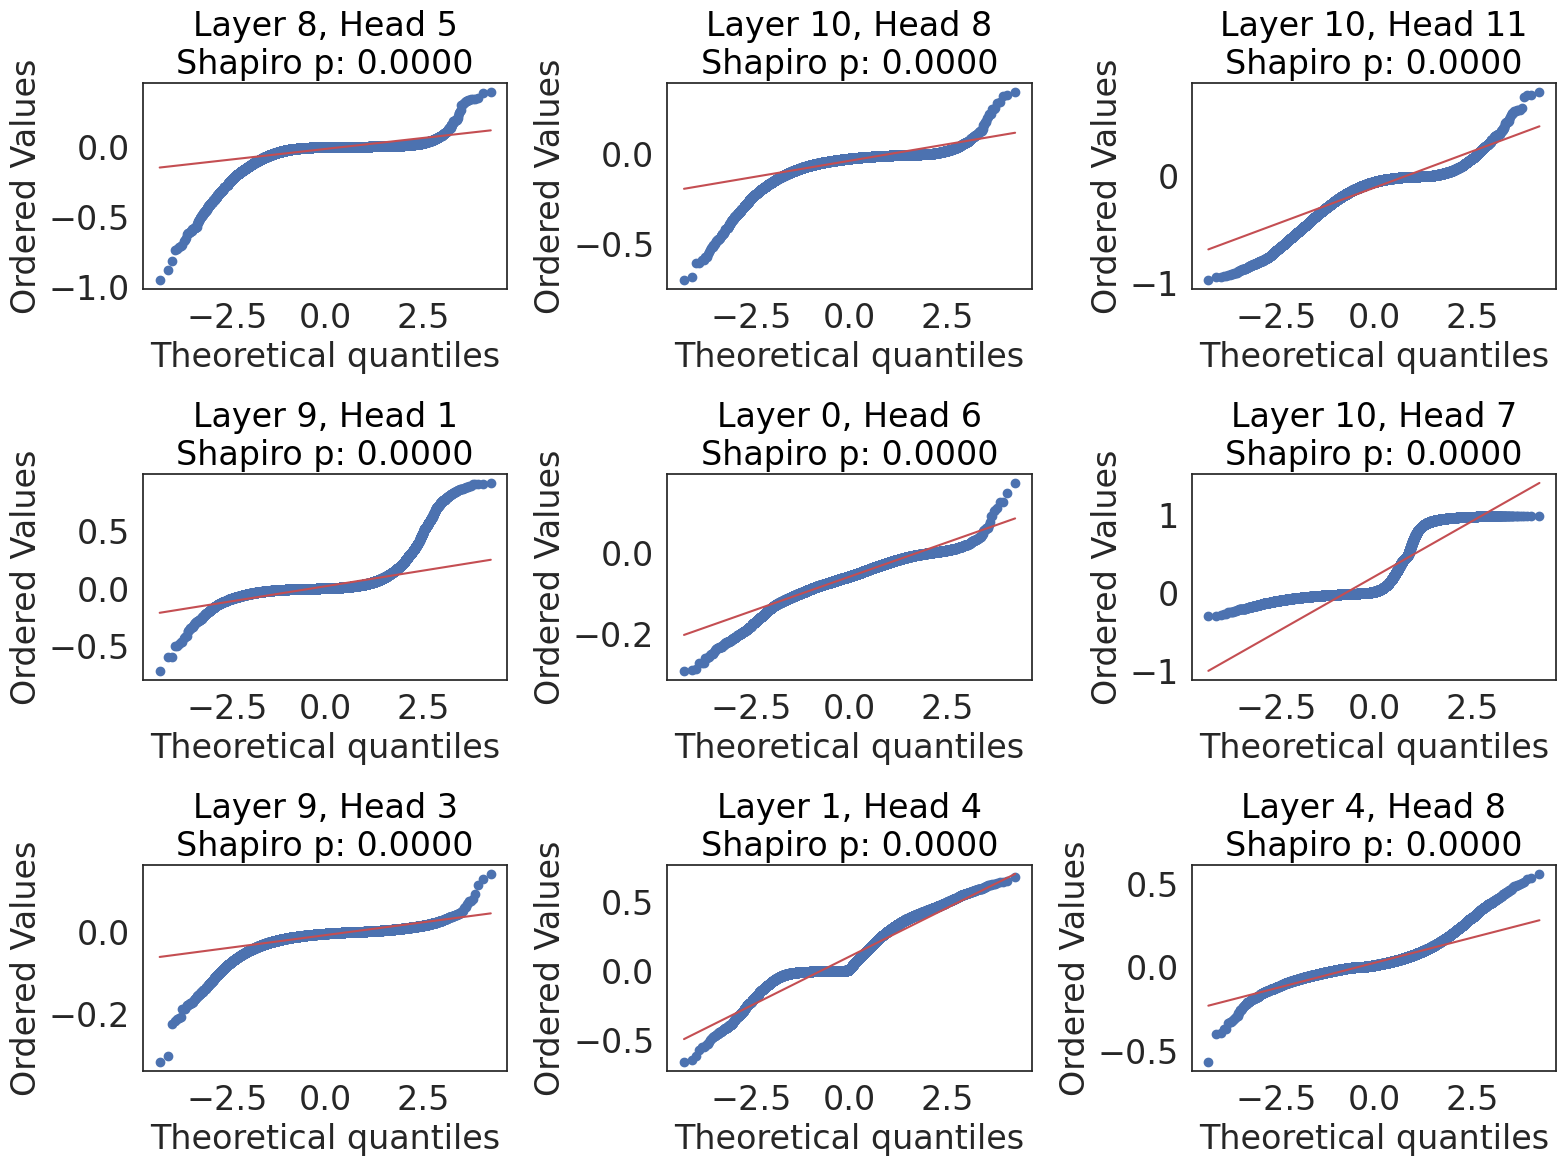

Checking normality for RuBERT-Polypers vs RuBERT-Finetuned:


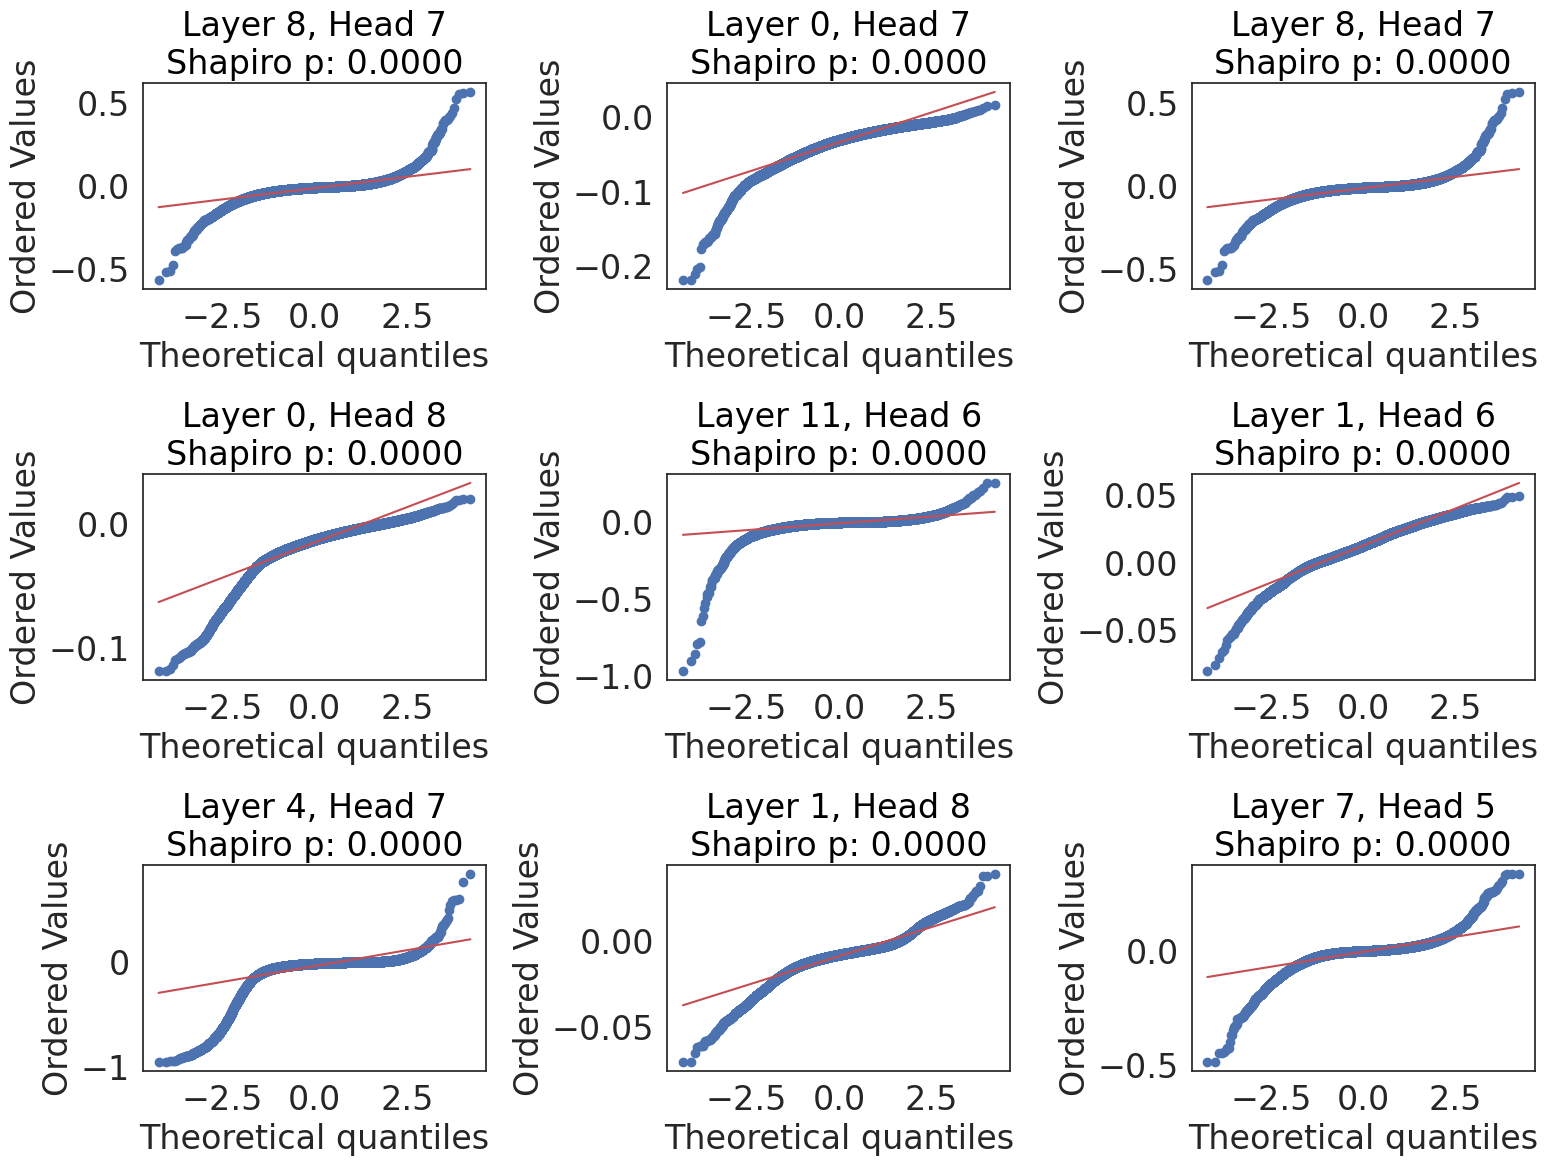

In [ ]:
def check_normality_assumption(model1, model2, n_samples=9):
    """Check if differences are normally distributed for sample layer-head pairs"""
    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    axes = axes.flatten()

    # Sample random layer-head combinations
    layers = np.random.randint(0, 12, n_samples)
    heads = np.random.randint(0, 12, n_samples)

    for i, (layer, head) in enumerate(zip(layers, heads)):
        differences = model1[:, layer, head] - model2[:, layer, head]

        # Q-Q plot for normality check
        stats.probplot(differences, dist="norm", plot=axes[i])
        axes[i].set_title(f"Layer {layer}, Head {head}\nShapiro p: {stats.shapiro(differences)[1]:.4f}")

    plt.tight_layout()
    plt.show()

print("Checking normality for RuBERT-Finetuned vs RuBERT:")
check_normality_assumption(finetuned_regular_attns, default_attns)

print("Checking normality for RuBERT-Polypers vs RuBERT:")
check_normality_assumption(finetuned_polypers_attns, default_attns)

print("Checking normality for RuBERT-Polypers vs RuBERT-Finetuned:")
check_normality_assumption(finetuned_polypers_attns, finetuned_regular_attns)

In [ ]:
def compute_matched_pairs_rank_biserial(x, y):
    """
    Compute matched pairs rank-biserial correlation (effect size for Wilcoxon signed-rank test)
    Formula: r = (W+ - W-) / (W+ + W-)
    where W+ is sum of positive ranks, W- is sum of negative ranks
    Results are identical to the implementation in the pingouin library
    """
    # Calculate differences
    d = x - y
    # Remove zeroes
    d = d[d != 0]

    if len(d) == 0:
        return 0.0

    # Get ranks of absolute differences
    ranks = stats.rankdata(np.abs(d))

    # Calculate W+ and W-
    W_plus = np.sum(ranks[d > 0])
    W_minus = np.sum(ranks[d < 0])

    # Compute rank-biserial correlation
    r = (W_plus - W_minus) / (W_plus + W_minus)

    return r

In [ ]:
def perform_wilcoxon_with_effect_size(model1, model2, alpha=0.05):
    """Perform Wilcoxon signed-rank tests with rank-biserial effect size"""
    n_layers, n_heads = model1.shape[1], model1.shape[2]
    p_values = np.zeros((n_layers, n_heads))
    effect_sizes = np.zeros((n_layers, n_heads))
    statistics = np.zeros((n_layers, n_heads))

    for layer in range(n_layers):
        for head in range(n_heads):
            # Wilcoxon signed-rank test (two-sided)
            stat, p_val = stats.wilcoxon(model1[:, layer, head],
                                       model2[:, layer, head],
                                       alternative="two-sided")
            p_values[layer, head] = p_val
            statistics[layer, head] = stat

            # Compute effect size
            effect_sizes[layer, head] = compute_matched_pairs_rank_biserial(
                model1[:, layer, head], model2[:, layer, head])

    # Apply FDR correction
    p_flat = p_values.flatten()
    _, p_corrected, _, _ = multipletests(p_flat, alpha=alpha, method="fdr_bh")
    p_corrected = p_corrected.reshape((n_layers, n_heads))

    return p_values, p_corrected, statistics, effect_sizes

print("Comparing Polypersonal model vs Default model")
p_polypers_vs_default, p_corr_polypers_vs_default, stats_polypers_vs_default, effects_polypers_vs_default = \
    perform_wilcoxon_with_effect_size(finetuned_polypers_attns, default_attns)

print("Comparing Polypersonal model vs Regular Finetuned model")
p_polypers_vs_regular, p_corr_polypers_vs_regular, stats_polypers_vs_regular, effects_polypers_vs_regular = \
    perform_wilcoxon_with_effect_size(finetuned_polypers_attns, finetuned_regular_attns)

print("Comparing Regular Finetuned model vs Default model")
p_regular_vs_default, p_corr_regular_vs_default, stats_regular_vs_default, effects_regular_vs_default = \
    perform_wilcoxon_with_effect_size(finetuned_regular_attns, default_attns)

Comparing Polypersonal model vs Default model
Comparing Polypersonal model vs Regular Finetuned model
Comparing Regular Finetuned model vs Default model


In [ ]:
def output_differences(effect_sizes, p_corrected, title, alpha=0.05):
    print(title)
    significant_mask = p_corrected < alpha

    for layer in range(effect_sizes.shape[0]):
        for head in range(effect_sizes.shape[1]):
            if not significant_mask[layer, head]:
                p_val = p_corrected[layer, head]
                print(f"Insignificant difference: Layer {layer}, Head {head}. p-value = {p_val}")
    print()

output_differences(
    effects_polypers_vs_default, p_corr_polypers_vs_default,
    "RuBERT-Polypers vs RuBERT")

output_differences(
    effects_polypers_vs_regular, p_corr_polypers_vs_regular,
    "RuBERT-Polypers vs RuBERT-Finetuned")

output_differences(
    effects_regular_vs_default, p_corr_regular_vs_default,
    "RuBERT-Finetuned vs. RuBERT")

RuBERT-Polypers vs RuBERT

RuBERT-Polypers vs RuBERT-Finetuned

RuBERT-Finetuned vs. RuBERT
Insignificant difference: Layer 6, Head 0. p-value = 0.5321324581230027
Insignificant difference: Layer 9, Head 10. p-value = 0.11681773376992258



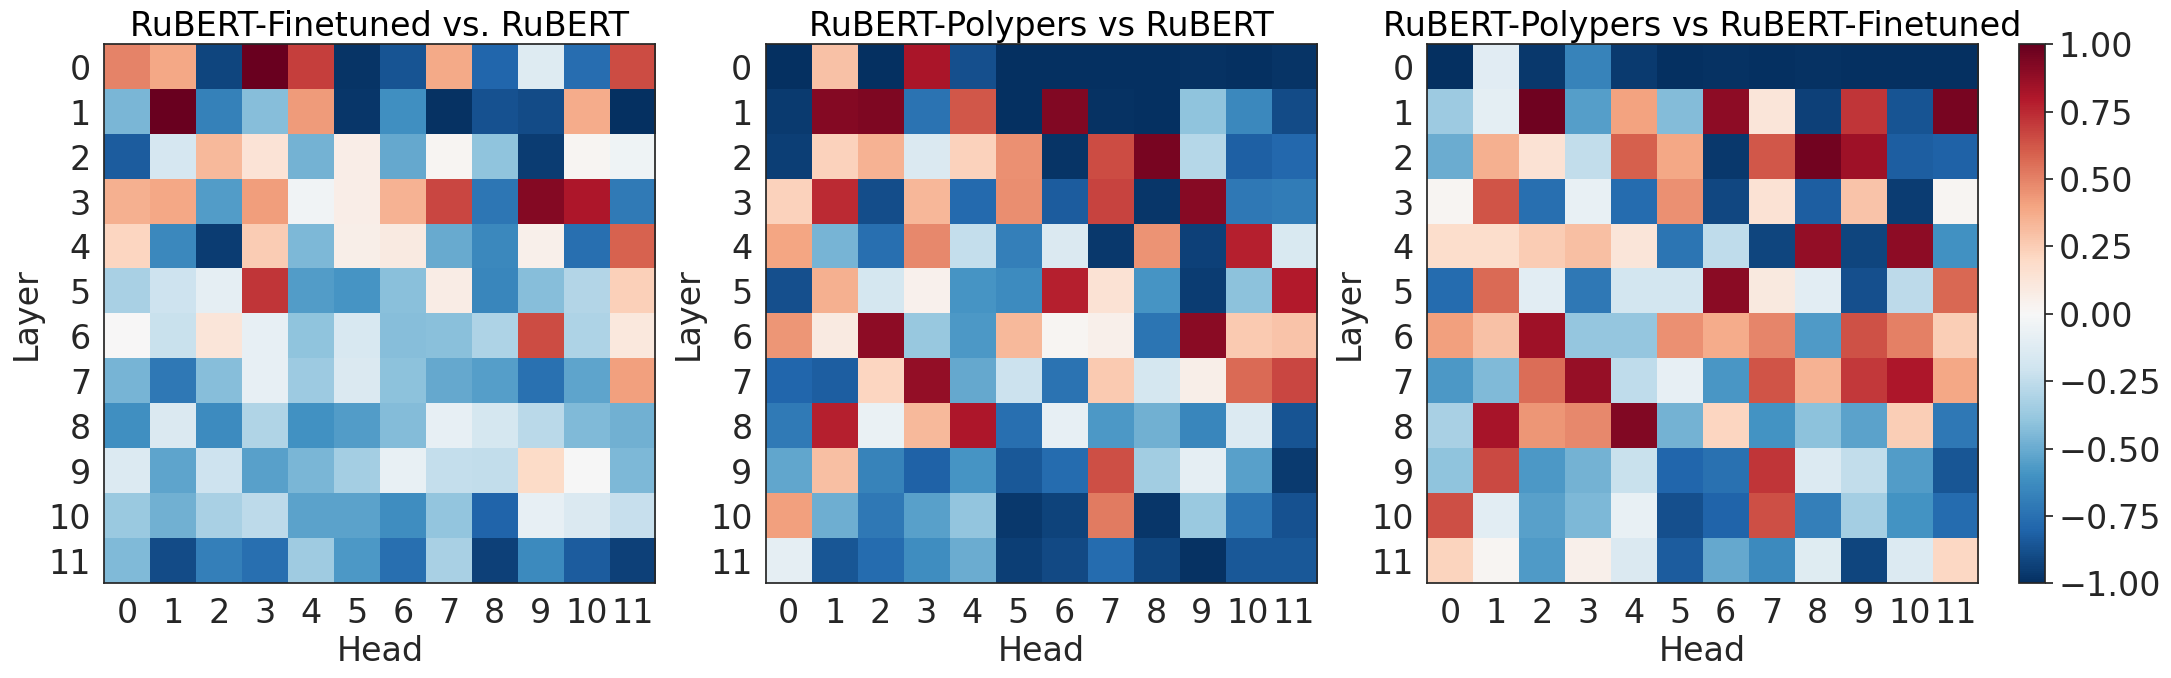

In [ ]:
plot_three_heatmaps(
    [effects_regular_vs_default, effects_polypers_vs_default, effects_polypers_vs_regular],
    ["RuBERT-Finetuned vs. RuBERT", "RuBERT-Polypers vs RuBERT", "RuBERT-Polypers vs RuBERT-Finetuned"],
    save_path="effect_sizes.pgf",
    vmin=-1, vmax=1
)

In [ ]:
def identify_important_heads(effect_sizes, p_corrected, comparison_name, top_k=10, alpha=0.05):
    """Identify top positive and negative effect heads"""
    # Filter only significant effects
    significant_mask = p_corrected < alpha
    significant_effects = effect_sizes[significant_mask]
    significant_indices = np.where(significant_mask)

    # Create list of significant head information
    heads_info = []
    for i in range(len(significant_effects)):
        layer = significant_indices[0][i]
        head = significant_indices[1][i]
        effect = significant_effects[i]
        p_val = p_corrected[layer, head]

        heads_info.append({
            "layer": layer,
            "head": head,
            "effect_size": effect,
            "p_value": p_val,
            "direction": "positive" if effect > 0 else "negative"
        })

    # Sort by absolute effect size
    heads_info.sort(key=lambda x: abs(x["effect_size"]), reverse=True)

    # Separate positive and negative
    positive_heads = [h for h in heads_info if h["effect_size"] > 0]
    negative_heads = [h for h in heads_info if h["effect_size"] < 0]

    print(f"\n{comparison_name}")
    print("=" * 60)

    print(f"\nTop {min(top_k, len(positive_heads))} Positive Effects (Polypersonal > Comparison):")
    print("Layer\tHead\tEffect Size\tp-value")
    print("-" * 40)
    for head_info in positive_heads[:top_k]:
        print(f"{head_info['layer']}\t{head_info['head']}\t{head_info['effect_size']:.4f}\t{head_info['p_value']:.6f}")

    print(f"\nTop {min(top_k, len(negative_heads))} Negative Effects (Polypersonal < Comparison):")
    print("Layer\tHead\tEffect Size\tp-value")
    print("-" * 40)
    for head_info in negative_heads[:top_k]:
        print(f"{head_info['layer']}\t{head_info['head']}\t{head_info['effect_size']:.4f}\t{head_info['p_value']:.6f}")

    print(f"\nSummary:")
    print(f"Total significant heads: {len(heads_info)}")
    print(f"Positive effects: {len(positive_heads)}")
    print(f"Negative effects: {len(negative_heads)}")
    if len(heads_info) > 0:
        print(f"Mean absolute effect size: {np.mean(np.abs(significant_effects)):.4f}")
        print(f"Max effect size: {np.max(np.abs(significant_effects)):.4f}")

    return positive_heads, negative_heads

pos_polypers_vs_default, neg_polypers_vs_default = identify_important_heads(
    effects_polypers_vs_default, p_corr_polypers_vs_default,
    "POLYPERSONAL vs DEFAULT MODEL", top_k=10)

pos_polypers_vs_regular, neg_polypers_vs_regular = identify_important_heads(
    effects_polypers_vs_regular, p_corr_polypers_vs_regular,
    "POLYPERSONAL vs REGULAR FINETUNED MODEL", top_k=10)


POLYPERSONAL vs DEFAULT MODEL

Top 10 Positive Effects (Polypersonal > Comparison):
Layer	Head	Effect Size	p-value
----------------------------------------
2	8	0.9497	0.000000
1	2	0.9366	0.000000
1	6	0.9251	0.000000
1	1	0.9147	0.000000
3	9	0.9091	0.000000
6	9	0.9056	0.000000
6	2	0.8919	0.000000
7	3	0.8775	0.000000
0	3	0.8150	0.000000
8	4	0.8094	0.000000

Top 10 Negative Effects (Polypersonal < Comparison):
Layer	Head	Effect Size	p-value
----------------------------------------
0	5	-1.0000	0.000000
0	7	-1.0000	0.000000
0	10	-0.9992	0.000000
1	5	-0.9974	0.000000
0	8	-0.9972	0.000000
1	8	-0.9969	0.000000
0	2	-0.9967	0.000000
0	6	-0.9963	0.000000
0	0	-0.9939	0.000000
1	7	-0.9915	0.000000

Summary:
Total significant heads: 144
Positive effects: 49
Negative effects: 95
Mean absolute effect size: 0.6244
Max effect size: 1.0000

POLYPERSONAL vs REGULAR FINETUNED MODEL

Top 10 Positive Effects (Polypersonal > Comparison):
Layer	Head	Effect Size	p-value
----------------------------------------


example where means are very close but matched-pairs rank-biserial correlation is high

In [ ]:
compute_matched_pairs_rank_biserial(finetuned_polypers_attns[..., 1, 2], finetuned_regular_attns[..., 1, 2])

np.float64(0.9693544184632296)

In [ ]:
finetuned_polypers_attns[..., 1, 2].mean() - finetuned_regular_attns[..., 1, 2].mean()

np.float64(0.000206035050024804)